最简化仿真代码（非训练）

In [ ]:
import sys
import os
import numpy as np
import torch as th
from math import *
# 获取project目录
def get_current_file_dir():
    # 判断是否在 Jupyter Notebook 环境
    try:
        shell = get_ipython().__class__.__name__  # ← 误报，不用管
        if shell == 'ZMQInteractiveShell':  # Jupyter Notebook 或 JupyterLab
            # 推荐用 os.getcwd()，指向启动 Jupyter 的目录
            return os.getcwd()
        else:  # 其他 shell
            return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # 普通 Python 脚本
        return os.path.dirname(os.path.abspath(__file__))

current_dir = get_current_file_dir()
sys.path.append(os.path.dirname(current_dir))
from Envs.UAVmodel6d import UAVModel
from Math_calculates.CartesianOnEarth import NUE2LLH, LLH2NUE

# class height_track

o00 = np.array([118, 30])  # 地理原点的经纬
DEFAULT_RED_BIRTH_STATE = {'position': np.array([-38000.0, 8000.0, 0.0]),
                               'psi': 0
                               }
dt_move=0.02
UAV = UAVModel(dt=dt_move)
UAV.ammo = 0
UAV.id = 1
UAV.red = True
UAV.blue = False
UAV.label = "red"
UAV.color = np.array([1, 0, 0])
# 红方出生点
UAV.pos_ = DEFAULT_RED_BIRTH_STATE['position']
UAV.speed = 300  # (UAV.speed_max - UAV.speed_min) / 2
speed = UAV.speed
UAV.psi = DEFAULT_RED_BIRTH_STATE['psi']
UAV.theta = 0 * pi / 180
UAV.gamma = 0 * pi / 180
UAV.vel_ = UAV.speed * np.array([cos(UAV.theta) * cos(UAV.psi),
                                    sin(UAV.theta),
                                    cos(UAV.theta) * sin(UAV.psi)])
lon_uav, lat_uav, h_uav = NUE2LLH(UAV.pos_[0], UAV.pos_[1], UAV.pos_[2], lon_o=o00[0], lat_o=o00[1], h_o=0)
UAV.reset(lon0=lon_uav, lat0=lat_uav, h0=h_uav, v0=UAV.speed, psi0=UAV.psi, phi0=UAV.gamma,
            theta0=UAV.theta, o00=o00)

action = [0,0,0]

target_height = 3000 + (action[0] + 1) / 2 * (10000 - 3000)  # 高度使用绝对数值
delta_heading = action[1]  # 相对方位(弧度)
target_speed = 170 + (action[2] + 1) / 2 * (544 - 170)  # 速度使用绝对数值
# print('target_height',target_height)
# for i in range(int(self.dt // dt_move)):
t_last = 60

tacview_show = 1

if tacview_show:
    from Visualize.tacview_visualize import *
    tacview = Tacview()

for i in range(int(t_last//dt_move)):
    current_t = i*dt_move
    UAV.move(target_height, delta_heading, target_speed)
    loc_r = [UAV.lon, UAV.lat, UAV.alt]
    if tacview_show:
        data_to_send = ''
        data_to_send += "#%.2f\n%s,T=%.6f|%.6f|%.6f|%.6f|%.6f|%.6f,Name=F16,Color=Red\n" % (
                float(current_t), UAV.id, loc_r[0], loc_r[1], loc_r[2], UAV.phi * 180 / pi, UAV.theta * 180 / pi,
                UAV.psi * 180 / pi)
    if tacview_show:
            tacview.send_data_to_client(data_to_send)



高度追踪训练

Iteration: 100%|██████████| 200/200 [09:19<00:00,  2.80s/it, episode=200, return=660.385]
c:\Users\LYH\miniforge3\envs\38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LYH\miniforge3\envs\38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LYH\miniforge3\envs\38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LYH\miniforge3\envs\38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


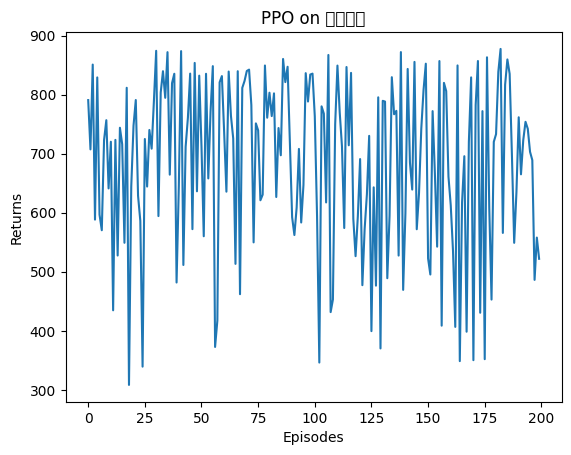

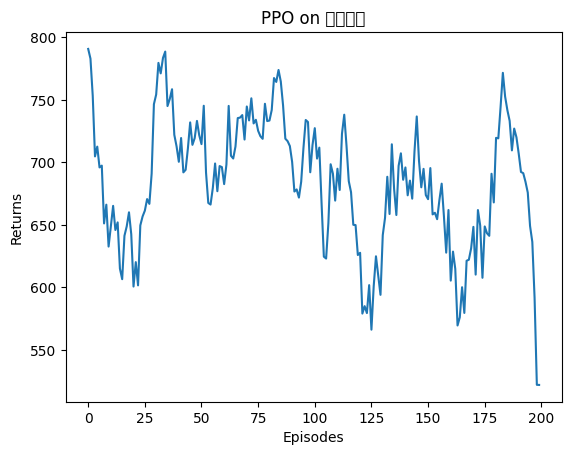

In [3]:
import sys
import os
import numpy as np
import torch as th
from math import *
from gym import spaces
import copy

# 获取project目录
def get_current_file_dir():
    # 判断是否在 Jupyter Notebook 环境
    try:
        shell = get_ipython().__class__.__name__  # ← 误报，不用管
        if shell == 'ZMQInteractiveShell':  # Jupyter Notebook 或 JupyterLab
            # 推荐用 os.getcwd()，指向启动 Jupyter 的目录
            return os.getcwd()
        else:  # 其他 shell
            return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # 普通 Python 脚本
        return os.path.dirname(os.path.abspath(__file__))

current_dir = get_current_file_dir()
sys.path.append(os.path.dirname(current_dir))
from Envs.UAVmodel6d import UAVModel
from Math_calculates.CartesianOnEarth import NUE2LLH, LLH2NUE
from Visualize.tacview_visualize import *
from Visualize.tensorboard_visualize import *
from Algorithms.SquashedPPOcontinues import *

class height_track_env():
    def __init__(self, dt_move=0.02):
        super(height_track_env, self).__init__()
        self.UAV_ids = None
        self.dt_report = None
        self.dt_move = dt_move
        self.t = None
        # self.done = None
        self.success = None # 胜
        self.fail = None # 负
        self.draw = None # 平
        self.action_space = [spaces.Box(low=-1, high=+1, shape=(3,), dtype=np.float32)]
        self.DEFAULT_RED_BIRTH_STATE = {'position': np.array([-38000.0, 8000.0, 0.0]),
                               'psi': 0
                               }
        
        # 高于升限会导致动作无法实施，影响
        self.time_limit = 180
        self.min_alt = 1e3
        self.min_alt_save = 3e3
        self.max_alt_save = 14e3
        self.max_alt = 15e3

        # △h动作输出有效性测试
        self.height_req = None
        
        self.tacview_show = None
    
    def reset(self, o00=None, birth_state=None, height_req=8e3, dt_report = 0.2, t0=0, tacview_show=0):
        self.tacview_show = tacview_show
        self.t = t0
        self.success = 0
        # self.done = 0
        self.fail = 0
        self.draw = 0
        if o00 == None:
            o00 = np.array([118, 30])  # 地理原点的经纬
        if birth_state == None:
            birth_state = self.DEFAULT_RED_BIRTH_STATE
        self.dt_report = dt_report
        UAV = UAVModel(dt=self.dt_move)
        UAV.ammo = 0
        UAV.id = 1
        UAV.red = True
        UAV.blue = False
        UAV.label = "red"
        UAV.color = np.array([1, 0, 0])
        # 红方出生点
        UAV.pos_ = self.DEFAULT_RED_BIRTH_STATE['position']
        UAV.speed = 300  # (UAV.speed_max - UAV.speed_min) / 2
        speed = UAV.speed
        UAV.psi = self.DEFAULT_RED_BIRTH_STATE['psi']
        UAV.theta = 0 * pi / 180
        UAV.gamma = 0 * pi / 180
        UAV.vel_ = UAV.speed * np.array([cos(UAV.theta) * cos(UAV.psi),
                                            sin(UAV.theta),
                                            cos(UAV.theta) * sin(UAV.psi)])
        lon_uav, lat_uav, h_uav = NUE2LLH(UAV.pos_[0], UAV.pos_[1], UAV.pos_[2], lon_o=o00[0], lat_o=o00[1], h_o=0)
        UAV.reset(lon0=lon_uav, lat0=lat_uav, h0=h_uav, v0=UAV.speed, psi0=UAV.psi, phi0=UAV.gamma,
                    theta0=UAV.theta, o00=o00)
        self.UAV = UAV
        
        # △h动作输出有效性测试
        self.height_req = height_req

        if tacview_show:
            self.tacview = Tacview()


    def get_obs(self):
        '''
        0 h abs /5e3 m
        1 h_dot /340 m/s
        2 sin θ_v
        3 cos θ_v
        4 sin φ
        5 cos φ
        6 v /340 m/s
        '''
        obs = np.zeros(7)
        obs[0] = self.UAV.alt / 5e3
        obs[1] = self.UAV.climb_rate /340
        v_hor = abs(self.UAV.vel_[0]**2+self.UAV.vel_[2]**2)
        theta_v = np.arctan2(self.UAV.vel_[1], v_hor)
        obs[2] = sin(theta_v)
        obs[3] = cos(theta_v)
        obs[4] = sin(self.UAV.phi)
        obs[5] = cos(self.UAV.phi)
        obs[6] = self.UAV.speed /340
        
        return obs


    def get_obs_spaces(self):
        self.reset()
        obs = self.get_obs()
        self.obs_spaces = [spaces.Box(low=-np.inf, high=+np.inf, shape=obs1.shape, dtype=np.float32) for obs1 in obs]
        return self.obs_spaces

    def step(self, action):
        target_height, delta_heading, target_speed = action
        self.t += self.dt_report
        time_rate = int(round(self.dt_report/self.dt_move))
        for _ in range(time_rate):
            self.UAV.move(target_height, delta_heading, target_speed, relevant_height=True, relevant_speed=False)
            done = self.get_done()
            # 单智能体特例
            if self.fail:
                break
        next_obs = self.get_obs()
        # done = self.get_done()
        reward = self.get_reward()
        
        return next_obs, reward, done


    def get_done(self):
        done = 0
        # 高度追踪失败条件：跑出h_min~h_max的范围立即失败
        h_current = self.UAV.alt
        if h_current<self.min_alt or h_current>self.max_alt:
            done = 1
            self.fail = 1
            return done
        
        # 高度保持成功条件：到时间结束为止没有超出距离
        if self.t>=self.time_limit:
            done = 1
            return done
        
        # 立即成功条件(暂时不做）：距离h_req小于100m，且爬升率绝对值小于10m/s
        pass
        return done


    def get_reward(self, ):
        # 高度奖励
        h_current = self.UAV.alt
        h_req = self.height_req
        r_h_norm = (h_current<=h_req)*(h_current-self.min_alt)/(h_req-self.min_alt)+\
                    (h_current>h_req)*(1-(h_current-h_req)/(self.max_alt-h_req))
        r_h_norm = 1 * r_h_norm
        # 高度出界惩罚
        if self.fail:
            r_h_norm -= 10
        if self.success:
            r_h_norm += 3
        
        # 其他奖励待续
        return r_h_norm
        

    def reder(self,):
        loc_r = [self.UAV.lon, self.UAV.lat, self.UAV.alt]
        if self.tacview_show:
            data_to_send = ''
            data_to_send += "#%.2f\n%s,T=%.6f|%.6f|%.6f|%.6f|%.6f|%.6f,Name=F16,Color=Red\n" % (
                    float(self.t), self.UAV.id, loc_r[0], loc_r[1], loc_r[2], self.UAV.phi * 180 / pi, self.UAV.theta * 180 / pi,
                    self.UAV.psi * 180 / pi)
            self.tacview.send_data_to_client(data_to_send)


env = height_track_env()
from tqdm import tqdm
obs_space = env.get_obs_spaces()
action_space = env.action_space

# dof = 3
# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200  # 2000
hidden_dim = [128]  # 128
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10
eps = 0.2

state_dim = 7  # env.observation_space.shape[0] # test
action_dim = 1 # test
action_bound = np.array([-1,1])  # 动作幅度限制
env_name = '高低测试'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

out_range_count = 0
return_list = []

# 训练
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': [], 'action_bounds': []}
        env.DEFAULT_RED_BIRTH_STATE['position'][1] = np.random.uniform(4000, 10000)
        env.reset(height_req=np.random.uniform(5000, 10000), tacview_show=0)
        state = env.get_obs()
        done = False
        while not done:  # 每个训练回合
            # 1.执行动作得到环境反馈
            action = agent.take_action(state, action_bounds=action_bound, explore=True)

            total_action = np.array([action[0], 0, 300])

            next_state, reward, done = env.step(total_action)

            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            transition_dict['action_bounds'].append(action_bound)
            state = next_state
            episode_return += reward

        if env.fail==1:
            out_range_count+=1
        return_list.append(episode_return)
        agent.update(transition_dict)
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

import matplotlib.pyplot as plt
episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))

mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))

plt.show()



In [ ]:

# 测试回合

env.reset(height_req=5e3, tacview_show=1)
step = 0
state = env.get_obs()
done = False
while not env.get_done():
    action = agent.take_action(state, action_bounds=action_bound, explore=True)

    total_action = np.array([action[0], 0, 300])

    next_state, reward, done = env.step(total_action)
    state = next_state
    # print(f"step={step} next_obs={next_obs} reward={reward} done={done}")
    step += 1
    env.reder()
    time.sleep(0.01)

